In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
features = pd.read_csv('AVUV.csv')

features.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-26,50.180000,51.689999,50.180000,50.202000,46.670872,3400
1,2019-09-27,50.490002,50.490002,49.900002,49.993999,46.477501,55600
2,2019-09-30,49.937000,50.349998,49.937000,50.111000,46.586266,6600
3,2019-10-01,50.740002,50.740002,49.063000,49.063000,45.611977,3000
4,2019-10-02,48.470001,48.509998,48.240002,48.358002,44.956573,20200


In [4]:
features.shape

(1144, 7)

In [5]:
import datetime

dates = features['Date']

dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

features['Date'] = pd.to_datetime(features['Date'])

features['Timestamp'] = features['Date'].astype(int) / 10**9

features[:5]

,Date,Open,High,Low,Close,Adj Close,Volume,Timestamp
0,2019-09-26,50.180000,51.689999,50.180000,50.202000,46.670872,3400,1.569456e+09
1,2019-09-27,50.490002,50.490002,49.900002,49.993999,46.477501,55600,1.569542e+09
2,2019-09-30,49.937000,50.349998,49.937000,50.111000,46.586266,6600,1.569802e+09
3,2019-10-01,50.740002,50.740002,49.063000,49.063000,45.611977,3000,1.569888e+09
4,2019-10-02,48.470001,48.509998,48.240002,48.358002,44.956573,20200,1.569974e+09


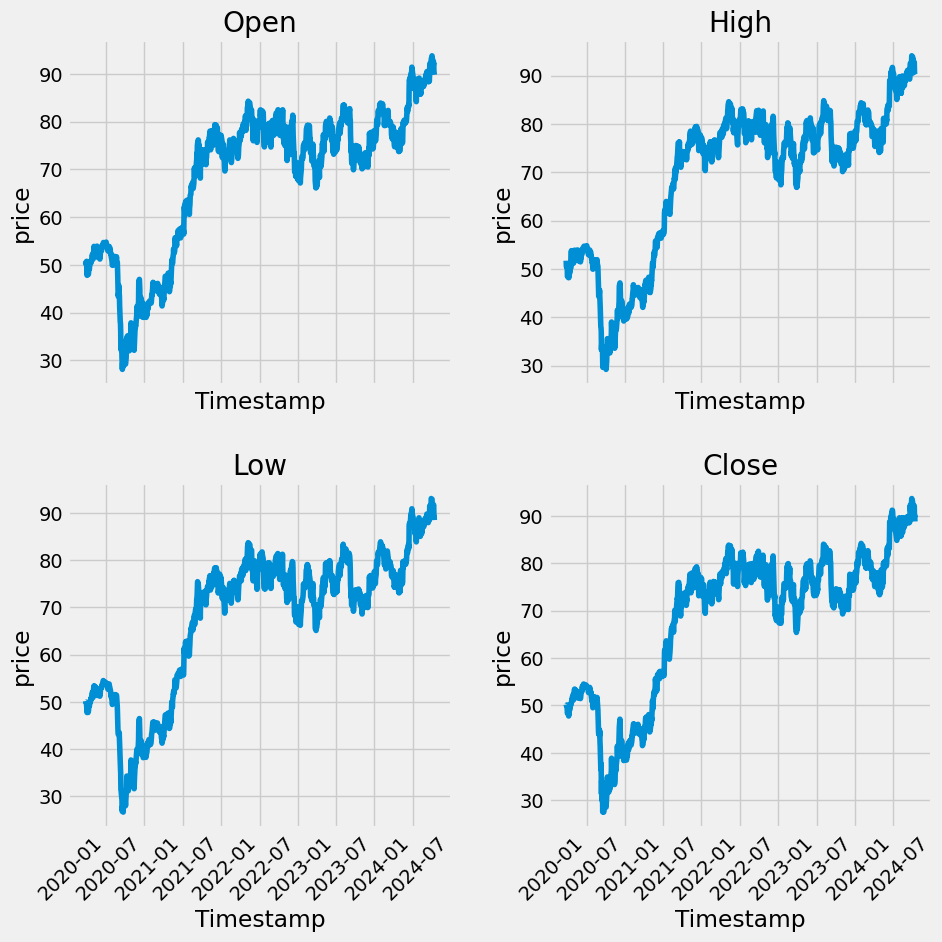

In [6]:
plt.style.use('fivethirtyeight')

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate(rotation = 45)

ax1.plot(dates,features['Open'])
ax1.set_xlabel('Timestamp'); ax1.set_ylabel('price'); ax1.set_title('Open')

ax2.plot(dates,features['High'])
ax2.set_xlabel('Timestamp'); ax2.set_ylabel('price'); ax2.set_title('High')

ax3.plot(dates,features['Low'])
ax3.set_xlabel('Timestamp'); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(dates,features['Close'])
ax4.set_xlabel('Timestamp'); ax4.set_ylabel('price'); ax4.set_title('Close')

plt.tight_layout(pad=2)

In [7]:
# 處理字串
import pandas as pd
import numpy as np

features = pd.read_csv('AVUV.csv')

features['Date'] = pd.to_datetime(features['Date'])

features = features.set_index('Date')

features = features.drop_duplicates()

features = features.fillna(method='ffill')  # forward fill

features['Year'] = features.index.year
features['Month'] = features.index.month
features['Day'] = features.index.day

def prepare_for_ml(df, target_col='Returns', sequence_length=10):
    data = []
    targets = []
    
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i+sequence_length]
        target = df.iloc[i+sequence_length][target_col]
        data.append(sequence.values)
        targets.append(target)
    
    return np.array(data), np.array(targets)
    
features = features.reset_index(drop=True)
features.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,50.180000,51.689999,50.180000,50.202000,46.670872,3400,2019,9,26
1,50.490002,50.490002,49.900002,49.993999,46.477501,55600,2019,9,27
2,49.937000,50.349998,49.937000,50.111000,46.586266,6600,2019,9,30
3,50.740002,50.740002,49.063000,49.063000,45.611977,3000,2019,10,1
4,48.470001,48.509998,48.240002,48.358002,44.956573,20200,2019,10,2


In [8]:
# 資料 y軸
labels = np.array(features['Open'])

# 去除標籤
features = features.drop('Open',axis = 1)

# 單獨保存其他標籤
feature_list = list(features.columns)

features = np.array(features)

In [9]:
features.shape

(1144, 8)

In [10]:
# 預處理
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [11]:
input_features[0]

array([-1.11584957, -1.143113  , -1.17487355, -1.21717924, -0.97759641,
       -1.8396954 ,  0.69019591,  1.17476279])

構建神經網路模型
--

In [23]:
# dtype = torch.float32
x = torch.tensor(input_features, dtype=torch.float32)

y = torch.tensor(labels, dtype=torch.float32)

# 權重參數初始化
weights = torch.randn((8,128),dtype = torch.float32, requires_grad = True)
biases = torch.randn(128,dtype = torch.float32, requires_grad = True)
weights2 = torch.randn((128,1),dtype = torch.float32, requires_grad = True)
biases2 = torch.randn(1,dtype = torch.float32, requires_grad = True)

learning_rate = 0.001
losses = []

for i in range(1000):
    
    hidden = x.mm(weights) + biases
    hideden = torch.relu(hidden)
    predictions = hidden.mm(weights2) + biases2

    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())

    if i % 100 == 0:
        print('loss: ', loss)
    loss.backward()

    # 梯度下降 Gradient Descent
    weights.data.add(- learning_rate * weights.grad.data)
    biases.data.add(- learning_rate * biases.grad.data)
    weights2.data.add(- learning_rate * weights2.grad.data)
    biases2.data.add(- learning_rate * biases2.grad.data)

    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)
loss:  tensor(7168.9888, grad_fn=<MeanBackward0>)


In [25]:
predictions.shape

torch.Size([1144, 1])

簡單的寫法
--

In [32]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [50]:
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad = True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 4.9783893
100 4.913069
200 4.85814
300 4.804146
400 4.7486176
500 4.6927023
600 4.6373215
700 4.583449
800 4.531223
900 4.4802423


訓練結果
--

In [55]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()

In [79]:
true_data = pd.DataFrame(data = {'date' : dates, 'actual' : labels})

months = features[:, feature_list.index('Month')]
days = features[:, feature_list.index('Day')]
years = features[:, feature_list.index('Year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date' : test_dates, 'prediction' : predict.reshape(-1)})

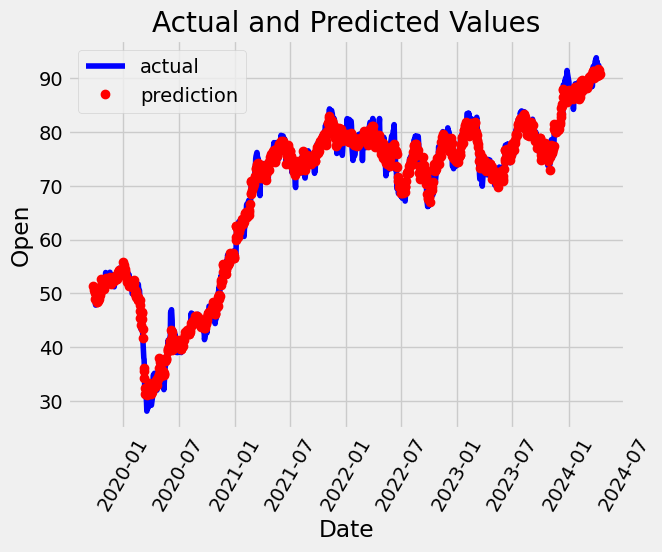

In [85]:
# 真實值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 預測值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60);
plt.legend()

# 圖名
plt.xlabel('Date'); plt.ylabel('Open'); plt.title('Actual and Predicted Values');
